In [14]:
import sys, os
from collections import defaultdict
from pathlib import Path
sys.path.append(os.path.abspath(os.path.join("..", "comparison_model")))

from model import MyComparisonModel

In [15]:

dataset_dir = Path("../../training/dataset")
splits = ['train', 'val', 'test']
overview = {split: defaultdict(int) for split in splits}

for split in splits:
    split_dir = dataset_dir / split
    for class_dir in split_dir.iterdir():
        if class_dir.is_dir():
            overview[split][class_dir.name] += len(list(class_dir.glob("*.jpg")))

import pandas as pd
df = pd.DataFrame(overview).fillna(0).astype(int)
df

,train,val,test
apple,91,19,21
banana,91,19,21
other,141,30,31


In [16]:
sys.path.append(os.path.abspath(os.path.join("..", "comparison_model")))
from model import MyComparisonModel
from data import get_dataloaders

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load data
dataset_dir = os.path.abspath(os.path.join("..", "dataset"))
train_loader, val_loader, test_loader = get_dataloaders(dataset_dir, train_transform, val_transform, batch_size=32)

# Model
model = MyComparisonModel().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    start_time = time.time()

    # Training
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    elapsed = time.time() - start_time

    print(f"Epoch {epoch+1:02d} | Time: {elapsed:.1f}s | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 01 | Time: 34.5s | Train Acc: 0.5294 | Val Acc: 0.2794
Epoch 02 | Time: 31.1s | Train Acc: 0.6873 | Val Acc: 0.6176
Epoch 03 | Time: 28.8s | Train Acc: 0.7957 | Val Acc: 0.8235
Epoch 04 | Time: 35.2s | Train Acc: 0.7802 | Val Acc: 0.7794
Epoch 05 | Time: 29.1s | Train Acc: 0.8297 | Val Acc: 0.8529
Epoch 06 | Time: 31.9s | Train Acc: 0.8885 | Val Acc: 0.8676
Epoch 07 | Time: 29.7s | Train Acc: 0.8452 | Val Acc: 0.8676
Epoch 08 | Time: 29.5s | Train Acc: 0.9195 | Val Acc: 0.8529
Epoch 09 | Time: 29.4s | Train Acc: 0.9102 | Val Acc: 0.8824
Epoch 10 | Time: 27.6s | Train Acc: 0.8854 | Val Acc: 0.8529
Epoch 11 | Time: 29.3s | Train Acc: 0.8978 | Val Acc: 0.8676
Epoch 12 | Time: 28.3s | Train Acc: 0.9195 | Val Acc: 0.7794
Epoch 13 | Time: 27.6s | Train Acc: 0.8978 | Val Acc: 0.8676
Epoch 14 | Time: 26.8s | Train Acc: 0.9040 | Val Acc: 0.8529
Epoch 15 | Time: 40.1s | Train Acc: 0.9102 | Val Acc: 0.7941
Epoch 16 | Time: 42.8s | Train Acc: 0.8700 | Val Acc: 0.8676
Epoch 17 | Time: 32.5s |

Classification Report:

              precision    recall  f1-score   support

       apple       0.95      0.86      0.90        21
      banana       0.95      1.00      0.98        21
       other       0.91      0.94      0.92        31

    accuracy                           0.93        73
   macro avg       0.94      0.93      0.93        73
weighted avg       0.93      0.93      0.93        73



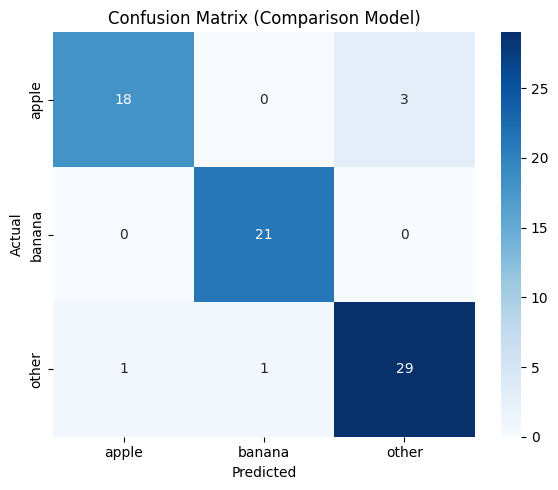

In [18]:
# Evaluate on test set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Report
class_names = test_loader.dataset.classes
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Comparison Model)")
plt.tight_layout()
plt.show()
